<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 CNN Object Localisation and Classification

The following builds a CNN for single-object localisation and classification. We will be using the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) which contains 7,349 images of cats and dogs, along with their breed. However, only ~3,500 have been annotated with bounding boxes, so we will just use those.

## 2.0 Import libraries

In [85]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from datasets import load_from_disk, disable_caching, DatasetDict
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data)
data_dir = os.path.join(path, 'data')

# Set the directory to the datasets folder (should be in shared/datasets/oxford_pets)
datasets_dir = os.path.join(path, '..', 'shared', 'datasets', 'oxford_pets')

# Set the directory to the shared models folder (should be in shared/models/oxford_pets)
model_dir = os.path.join(path, '..', 'shared', 'models', 'oxford_pets')

# Set the directory to the VGG weights file (should be in shared/models/vgg)
vgg_weights = os.path.join(path, '..', 'shared', 'models', 'vgg', 'vgg16_imagenet_weights.h5')

## 2.1 Load and pre-process  data

Dataset Features: ['image', 'image_name', 'breed', 'dog', 'pose', 'bbox', 'seg_mask']
Number of training images = 2579
Number of validation images = 553
Number of test images = 553


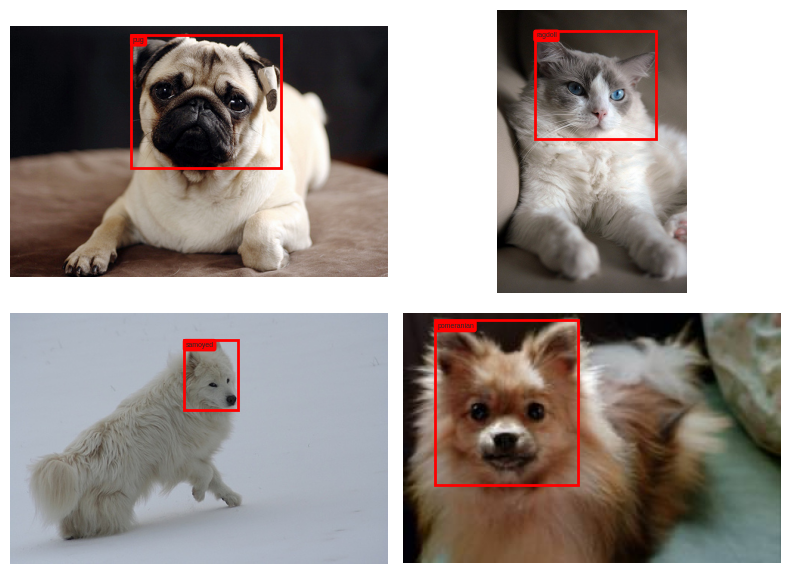

In [3]:
# Load the dataset (and disable caching)
disable_caching()
dataset = load_from_disk(datasets_dir)

# Split the dataset into train, validation and test
train_test = dataset.train_test_split(test_size=0.3, shuffle=True)
valid_test = train_test['test'].train_test_split(test_size=0.5, shuffle=True)
dataset = DatasetDict({'train': train_test['train'], 'valid': valid_test['train'], 'test': valid_test['test']})

print(f"Dataset Features: {list(dataset['train'].features.keys())}")
print(f"Number of training images = {dataset['train'].num_rows}")
print(f"Number of validation images = {dataset['valid'].num_rows}")
print(f"Number of test images = {dataset['test'].num_rows}")

# Display some random images
rand_index = np.random.choice(range(dataset['train'].num_rows), 4)
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax = axes.ravel()
for i in range(len(rand_index)):
    
    # Get image, bbox, and label
    image_index = int(rand_index[i])
    image = dataset['train'][image_index]['image']
    bbox = dataset['train'][image_index]['bbox']
    label = dataset['train'][image_index]['breed']

    # Plot the image
    ax[i].imshow(image)

    # Get the height and width of the bounding box
    height = bbox[3] - bbox[1]
    width = bbox[2] - bbox[0]
    # Draw the bounding box
    ax[i].add_patch(mpatches.Rectangle((bbox[0], bbox[1]), width, height, fill=False, edgecolor='red', linewidth=2))

    # Add the label
    ax[i].text(bbox[0]+2, bbox[1]+2, label, size=5,
            ha="left", va="top",
            bbox=dict(boxstyle="round", ec=(1.0, 0.0, 0.0), fc=(1.0, 0.0, 0.0)))
    ax[i].axis('off')
fig.tight_layout()
plt.show()

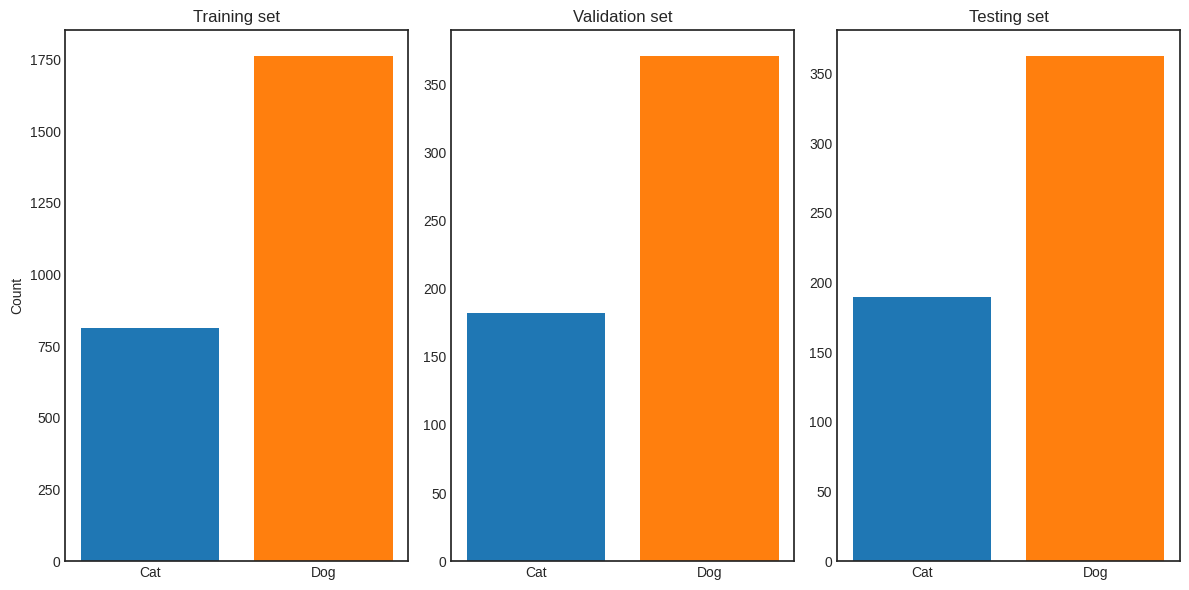

In [4]:
# Display the distribution of the pets
cmap = plt.get_cmap('tab10')
colours = cmap(range(2))
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
y_train = [x for x in dataset['train']['dog']]
ax[0].bar(np.unique(y_train), np.unique(y_train, return_counts=True)[1], color=colours)
ax[0].set_xticks(range(2), ['Cat', 'Dog'])
ax[0].set_title('Training set')
ax[0].set_ylabel('Count')

y_valid = [x for x in dataset['valid']['dog']]
ax[1].bar(np.unique(y_valid), np.unique(y_valid, return_counts=True)[1], color=colours)
ax[1].set_xticks(range(2), ['Cat', 'Dog'])
ax[1].set_title('Validation set')

y_test = [x for x in dataset['test']['dog']]
ax[2].bar(np.unique(y_test), np.unique(y_test, return_counts=True)[1], color=colours)
ax[2].set_xticks(range(2), ['Cat', 'Dog'])
ax[2].set_title('Testing set')
plt.tight_layout()
plt.show()

### Resize the images and convert to tf dataset

The images are currently various sizes and dimensions, so need to resize them into uniform dimensions. In this case 256 is appropriate.

However, when resizing the image we also need to resize the bounding boxes! This is much harder to do within a processing pipeline, because the images are fed into the network in batches. So instead simply create a function to apply to the dataset.

Bounding boxes are in VOC format [x_min, y_min, x_max, y_max], so only need to find the right scale to  transform the x and y values.

Finally, convert the Hugging Face 🤗 dataset to Tensorflow.

In [5]:
# Set the image dimensions
image_dim = 256
batch_size = 32

# Function to resize the images and bounding boxes
def resize(examples):

    for i in range(len(examples['image'])):

        # Original image size
        image_height = examples['image'][i].size[1]
        image_width = examples['image'][i].size[0]

        # Resize the image
        examples['image'][i] = examples['image'][i].convert("RGB").resize((image_dim, image_dim))

        # Original bounding box
        bbox = examples['bbox'][i]

        # Get the scale factor
        x_scale = image_dim / image_width
        y_scale = image_dim / image_height

        # Format of bbox is [x_min, y_min, x_max, y_max]
        examples['bbox'][i] = [int(bbox[0] * x_scale),
                            int(bbox[1] * y_scale),
                            int(bbox[2] * x_scale),
                            int(bbox[3] * y_scale)]

    return examples

if not grading:
    # Apply the preprocessing function to the dataset
    dataset = dataset.map(resize, batched=True)

    # Convert to tf dataset
    train = dataset['train'].to_tf_dataset(columns=['image'], label_cols=['dog', 'bbox'], batch_size=batch_size, shuffle=True)
    valid = dataset['valid'].to_tf_dataset(columns=['image'], label_cols=['dog', 'bbox'], batch_size=batch_size, shuffle=False)
    test = dataset['test'].to_tf_dataset(columns=['image'], label_cols=['dog', 'bbox'], batch_size=batch_size, shuffle=False)

Map:   0%|          | 0/2579 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

/opt/conda/lib/python3.11/site-packages/datasets/arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


<div class="alert alert-info" style="color:black"><h2>2.2 Exercise: Object localisation CNN</h2>

As we have seen, transfer learning is a highly effective method of building powerful models using the weights of large pre-trained image classifiers. Now we can create a CNN model that uses a pre-trained deep CNN model for feature extraction. Then we can add a few convolutional layers and two classifier 'heads', one performs the classification of the pet (dog or cat), the other performs regression to predict the coordinates of the bounding box.

You can copy/paste your code from the previous weeks exercise on transfer learning and adapt it according the following specification. 

1. In the following cell complete the `build_vgg_model()` function. It should take in the following arguments and return a Keras functional model:
    - `image_dim` is the *target* size for the input images, e.g. this is what they should be resized to.
    - `weights` is the *path* to the pre-trained VGG weights, e.g. `vgg_weights`.
    - `layers_list` is a list of tuples containing the number of filters and kernel size for each convolutional layer. Thus the length of the list is also the number of convolutional and pooling layers. For example: `[(16, 3), (32, 3)]` is two convolutional layers with 16 and 32 filters respectively and kernel size of 3.
    - `pool_size` is the size of the pooling operations.
    - `dropout` is the dropout rate for each intermediate dropout layer after a pooling layer.
    - `n_class` is the number of classes to predict, or the shape of the classifier output layer.
    - `n_regress` is the number of bounding box values to predict, or the shape of the regression output layer.
    - `optimiser` is the optimiser to use.
    - `lr` is the learning rate for the optimiser.

2. You don't need to resize the images (this has already been done) but you do need to rescale pixel values to the range [-1, 1] before input to the VGG layer.

3. When creating VGG:
    - You should set `include_top=False` so that the first fully-connected layer is not included.
    - **Make sure** you set `weights=weights` so that you don't download the weights, i.e. use the ones from the shared/models/vgg folder.
    - Set the model (used as a layer) to not trainable, e.g. `vgg.trainable=False`. Otherwise you will be fine tuning the whole network!

4. Following the VGG 'layer' create a several convolution, pool and dropout layers, as defined by the `layers_list`, `pool_size` and `dropout` parameters.

5. Next, apply global pooling, followed by the two classification and regression heads, named 'dog' and 'bbox' respectively to match the appropriate metrics.

6. You also need instantiate a custom Mean Intersection over Union (Mean IoU) metric to measure quality of predicted bounding boxes with respect to actual bounding boxes. The Keras metric doesn't work 'out of the box', because it does not apply argmax to sparse label representations, so need to create custom metric to update the state for each prediction. This code is provided for you. With multiple outputs and a custom metric we also need to define them when compiling the model, you can use the following `loss={'dog': 'binary_crossentropy', 'bbox': 'mae'}` and `metrics={'dog': 'accuracy', 'bbox': bbox_iou}`.

<br>
<b>This exercise is <u>not</u> marked.</b>
</div>

In [77]:
# Define the mean IoU metric
class BBoxMeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)
    
def build_vgg_model(image_dim, weights, layers_list, pool_size, dropout, n_class, n_regress, optimiser='adam', lr=0.001):
    """Builds a CNN object localisation model with the given parameters.
    
    Arguments:
        image_dim (tuple): The target dimensions of the input images
        weights (str): The weights to use for the VGG model
        layers_list (list): The list of tuples containing the number of filters and kernel size for each convolutional layer
        pool_size (int): The size of the max pooling layers
        dropout (int): The dropout rate
        n_class (int): The number of classes to predict
        n_regress (int): The number of regression outputs to predict
        optimiser (str): The optimiser to use
        lr (str): The optimiser learning rate to use
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.applications import VGG16
   
    inputs = layers.Input(shape=(None, None, 3))

    # 1. Rescale layer
    x = layers.Rescaling(1.0 / 255)(inputs)

    # 2. VGG base
    vgg = VGG16(include_top=False, weights=weights, input_shape=(image_dim[0], image_dim[1], 3))
    vgg.trainable = False
    x = vgg(x)

    # 3-8. Conv2D -> MaxPool -> Dropout layers (for each item in layers_list)
    for filters, kernel_size in layers_list:
        x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(pool_size=(pool_size, pool_size))(x)
        x = layers.Dropout(dropout)(x)

    # 9. Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # 10. Classification head
    class_output = layers.Dense(n_class, activation='sigmoid', name='dog')(x)

    # 11. Regression head
    bbox_output = layers.Dense(n_regress, name='bbox')(x)

    # Final model
    model = tf.keras.Model(inputs=inputs, outputs=[class_output, bbox_output])

    # Optimizer
    if optimiser == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError("Only 'adam' optimiser is supported in this test")

    # Compile
    model.compile(
        optimizer=opt,
        loss={'dog': 'binary_crossentropy', 'bbox': 'mae'},
        metrics={'dog': 'accuracy', 'bbox': BBoxMeanIoU(num_classes=2)}
    )
    return model

# Test
# # Test the number of layers
# print("Number of layers:", len(model.layers))

# # Test the model is a functional model
# print("Model type:", type(model))

# # Test the number of trainable parameters
# print("Number of trainable parameters:", model.count_params())

# # Test the size of the input shape
# print("Input shape:", model.input.shape)

# # Test the rescale layer
# print("Rescale layer type:", type(model.layers[1]))

# # Test the VGG model
# # print("VGG model type:", type(model.layers[2]))
# print("VGG model name:", model.layers[2].name)


Number of layers: 12
Model type: <class 'keras.src.models.functional.Functional'>
Number of trainable parameters: 18287429
Input shape: (None, None, None, 3)
Rescale layer type: <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
VGG model name: vgg16


In [78]:
# Test cell (0 marks)

# Create the model using the build_vgg_model function
layer_list = [(32, 5), (64, 3)]
model = build_vgg_model(
    image_dim=(128, 128),
    weights=vgg_weights,
    layers_list=layer_list,
    pool_size=2,
    dropout=0.2,
    n_class=1,
    n_regress=4,
    optimiser='adam',
    lr=0.001
)

# Test the model is a functional model
assert str(type(model)) == "<class 'keras.src.models.functional.Functional'>", 'Model should be a Functional Model'

# Test the number of layers
assert len(model.layers) == 12, 'Model should have 12 layers'

# Test the number of trainable parameters
assert model.count_params() == 15143141, 'Model should have 15143141 trainable parameters'

# Test the size of the input shape
assert model.input.shape == (None, None, None, 3), 'Input shape should be (None, None, None, 3)'

# Test the rescale layer
assert isinstance(model.layers[1], layers.Rescaling), 'Second layer should be the rescale layer'

# Test the VGG model
assert isinstance(model.layers[2], tf.keras.Model), 'Layer 2 should be a VGG model'
assert model.layers[2].name == 'vgg16', 'Layer 2 should be a VGG model'

# Test the convolution blocks
for i in range(len(layer_list)):
    j = 3 * i
    assert isinstance(model.layers[j+3], layers.Conv2D), f'Layer {j+3} should be a convolutional layer'
    assert model.layers[j+3].filters == layer_list[i][0], f'Layer {j+3} should have {layer_list[i][0]} filters'
    assert model.layers[j+3].kernel_size == (layer_list[i][1], layer_list[i][1]), f'Layer {j+3} should have a kernel size of ({layer_list[i][1]}, {layer_list[i][1]})'

    assert isinstance(model.layers[j+4], layers.MaxPooling2D), f'Layer {j+4} should be a max pooling layer'
    assert model.layers[j+4].pool_size == (2, 2), f'Layer {j+4} should have a pool size of (2, 2)'

    assert isinstance(model.layers[j+5], layers.Dropout), f'Layer {j+5} should be a dropout layer'
    assert model.layers[j+5].rate == 0.2, f'Layer {j+5} should have a dropout rate of 0.2'

# Test the global average pooling layer
assert isinstance(model.layers[9], layers.GlobalAveragePooling2D), 'Layer 9 should be a global average pooling layer'

# Test the classification and regression layers
assert isinstance(model.layers[10], layers.Dense), 'Layer 10 should be a dense layer'
assert model.layers[10].units == 1, 'Layer 10 should have 1 unit'
assert model.layers[10].name == 'dog', 'Layer 10 should be named dog'
assert model.layers[10].activation.__name__ == 'sigmoid', 'Layer 10 should have a sigmoid activation'
assert isinstance(model.layers[11], layers.Dense), 'Layer 11 should be a dense layer'
assert model.layers[11].units == 4, 'Layer 11 should have 4 units'
assert model.layers[11].name == 'bbox', 'Layer 11 should be named bbox'

# Test the optimiser
assert isinstance(model.optimizer, tf.keras.optimizers.Adam), 'Model should use the Adam optimiser'

# Test the learning rate
assert model.optimizer.learning_rate == 0.001, 'Model should have a learning rate of 0.001'

# Test the loss functions
assert model.loss['dog'] == 'binary_crossentropy', 'Model should use binary crossentropy for the classification loss'
assert model.loss['bbox'] == 'mae', 'Model should use mean absolute error for the regression loss'

# Test the metrics
assert model.get_compile_config()['metrics']['dog'] == 'accuracy', 'Model should use accuracy for the classification metric'
assert model.get_compile_config()['metrics']['bbox']['class_name'] == 'BBoxMeanIoU', 'Model should use the custom IoU metric for the regression metric'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (0 marks)
# Tests all function parameters with different values


### Build the object localisation CNN

In [79]:
layer_list = [(256, 5), (128, 3)]
model = build_vgg_model(
    image_dim=(image_dim, image_dim),
    weights=vgg_weights,
    layers_list=layer_list,
    pool_size=2,
    dropout=0.2,
    n_class=1,
    n_regress=4,
    optimiser='adam',
    lr=0.001
)

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_22        │ (None, None,      │          0 │ input_layer_40[0… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, None,      │ 14,714,688 │ rescaling_22[0][… │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, None,      │  3,277,056 │ vgg16[0][0]       │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, None,      │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, None,      │          0 │ max_pooling2d_21… │
│ (Dropout)           │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, None,      │    295,040 │ dropout_22[0][0]  │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, None,      │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, None,      │          0 │ max_pooling2d_22… │
│ (Dropout)           │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_23[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dog (Dense)         │ (None, 1)         │        129 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Dense)        │ (None, 4)         │        516 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,287,429 (69.76 MB)

 Trainable params: 3,572,741 (13.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Train and evaluate the model

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_chkptr = tf.keras.callbacks.ModelCheckpoint(
#             os.path.join(data_dir, 'pets_localisation_vgg.weights.h5'),
#             monitor='loss',
#             verbose=0,
#             save_best_only=True,
#             save_weights_only=True,
#             mode='min',
#             save_freq='epoch')

#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         min_delta=0.001,
#         patience=5,
#         verbose=0,
#         mode="min",
#         restore_best_weights=True)

#     # Fit the model
#     results = model.fit(train, validation_data=valid, epochs=100, callbacks=[model_chkptr, model_earlystp], verbose=2)
#     # Save the results
#     with open(os.path.join(data_dir, 'pets_localisation_vgg_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Train loss: 9.637
Train bbox iou: 0.786
Train dog accuracy: 0.984
Best validation loss: 11.739
Best validation bbox iou: 0.770
Best validation dog accuracy: 0.984


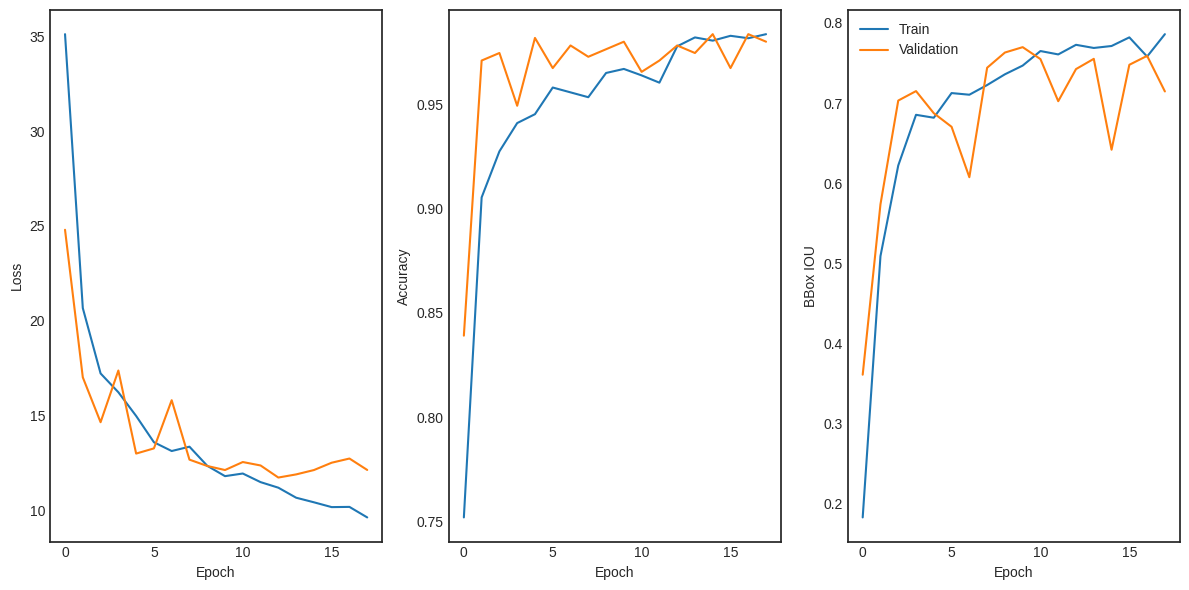

In [80]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 'pets_localisation_vgg_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:  
    # Or get them from model training
    metrics = results.history

print(f"Train loss: {min(metrics['loss']):.3f}")
print(f"Train bbox iou: {max(metrics['bbox_iou']):.3f}")
print(f"Train dog accuracy: {max(metrics['dog_accuracy']):.3f}")
print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
print(f"Best validation bbox iou: {max(metrics['val_bbox_iou']):.3f}")
print(f"Best validation dog accuracy: {max(metrics['val_dog_accuracy']):.3f}")

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=False)
ax = ax.flatten()
ax[0].plot(metrics['loss'], label='Train Dog Loss')
ax[0].plot(metrics['val_loss'], label='Validation Dog Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')

ax[1].plot(metrics['dog_accuracy'], label='Train Dog Accuracy')
ax[1].plot(metrics['val_dog_accuracy'], label='Validation Dog Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')

ax[2].plot(metrics['bbox_iou'], label='Train BBox IOU')
ax[2].plot(metrics['val_bbox_iou'], label='Validation BBox IOU')
ax[2].set(xlabel='Epoch', ylabel='BBox IOU')

plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [84]:
if not grading:
    # Load the best model
    model.load_weights(os.path.join(model_dir, 'pets_localisation_vgg.weights.h5'))

    # Evaluate the model on the test set
    metrics = model.evaluate(test, verbose=0)

    print(f"Test loss: {metrics[0]:.3f}")
    print(f"Test bbox iou: {metrics[1]:.3f}")
    print(f"Test dog accuracy: {metrics[2]:.3f}")

    # Predict class labels and bounding box for test set
    predictions = model.predict(test)

    class_predictions = [0 if x < 0.5 else 1 for x in predictions[0]] # Convert probabilities to binary
    y_test =[x for x in dataset['test']['dog']]

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, class_predictions, display_labels=['Cat', 'Dog'], colorbar=False)
    plt.show()

InvalidArgumentError: Graph execution error:

Detected at node ScatterNd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 724, in start

  File "/opt/conda/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/opt/conda/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/opt/conda/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue

  File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 501, in process_one

  File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell

  File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 731, in execute_request

  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 417, in do_execute

  File "/opt/conda/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/conda/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_114/3635182475.py", line 6, in <module>

  File "/opt/conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/opt/conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/opt/conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/opt/conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 91, in test_step

  File "/opt/conda/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 444, in compute_metrics

  File "/opt/conda/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/opt/conda/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "/tmp/ipykernel_114/3079720363.py", line 4, in update_state

  File "/opt/conda/lib/python3.11/site-packages/keras/src/metrics/iou_metrics.py", line 129, in update_state

  File "/opt/conda/lib/python3.11/site-packages/keras/src/metrics/metrics_utils.py", line 682, in confusion_matrix

  File "/opt/conda/lib/python3.11/site-packages/keras/src/ops/core.py", line 237, in scatter

  File "/opt/conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/core.py", line 354, in scatter

indices[0] = [2, 2] does not index into shape [2,2]
	 [[{{node ScatterNd}}]] [Op:__inference_one_step_on_iterator_9575]

### Qualitative evaluation of predicted bounding boxes

In [83]:
if not grading:
    # Get the predicted bounding box and true bounding box
    bbox_predictions = predictions[1]
    bbox_true = dataset['test']['bbox']

    # Display images in the test set with their predicted bounding box
    rand_index = np.random.choice(range(dataset['test'].num_rows), 4)
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    ax = axes.ravel()
    for i in range(len(rand_index)):
        image_index = int(rand_index[i])

        # Show the image
        image = dataset['test'][image_index]['image']
        ax[i].imshow(image)

        # Draw the predicted bounding box
        bbox = bbox_predictions[image_index]
        
        # Get the height and width of the bounding box
        x_min, y_min = bbox[0], bbox[1]
        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        ax[i].add_patch(mpatches.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2))
        
        # Draw the true bounding box
        bbox = bbox_true[image_index]
        
        # Get the height and width of the bounding box
        x_min, y_min = bbox[0], bbox[1]
        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        ax[i].add_patch(mpatches.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='green', linewidth=2))
        
        ax[i].axis('off')
    fig.tight_layout()
    plt.show()

NameError: name 'predictions' is not defined

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280